In [2]:
import numpy as np
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [3]:
def make_chains(mat, names, k, key):
    '''
        Создаёт k-цепочки по матрице смежности
        
        mat - матрица смежности
        
        names - список всех атомов в молекуле(По нему составляется имя)
        
        k - длина цепочки
        
        key - список имён цепочек(создаём такой, например в makeAllChains)
            если получим цепочку с таким названием, которого нет в словаре,
            то просто добавим цепочку с таким именем в словарь
    '''
    def dfs(que, mat, v, k_now, k_max, chainsDict, names):
        if k_now == k_max:
            name_in_num = list(que)
            name_in_num.sort()
            name_in_num = list(map(lambda i: names[i], name_in_num))
            kk = reduce(lambda i, j: i + j, name_in_num)
            chainsDict.setdefault(kk, 0)
            chainsDict[kk] += 1
            return
        
        for i in range(0, mat.shape[0]):
            if mat[v, i] == 1 and not i in que:
                que.append(i)
                dfs(que, mat, i, k_now + 1, k_max, chainsDict, names)
                del(que[k_now])
    
    
            
    chainsDict = dict.fromkeys(key, 0)
    
    for i in range(mat.shape[0]):#Запускаем обход в глубину k из каждой вершины
        que = []
        que.append(i)
        
        dfs(que, mat, i, 1, k, chainsDict, names)
        del(que[0])
        
        
    for i in chainsDict.keys(): #Каждую цепочку посчитали два раза
        chainsDict[i] //= 2
    return chainsDict
        

In [4]:
def generatorAdjMat(filename):
    """
        Функция-генератор матриц
        
        filename - имя файла из которого читать матрицы
    """
    with open(filename, "r") as f:
        for i in f:
            mol_atoms = []
            mol_name = i.split()[1]
            num_elems = int(i.split()[0])


            matrix = np.zeros((num_elems, num_elems))
            for i in range(num_elems):

                line = next(f) #Берём i линию в молекуле

                mol_atoms.append(line.split()[0]) #По первому индексу хранятся названия, которые пихаем в лист

                it = 3 #С третьего элемента в строке начинаются связи
                while line.split()[it] != "00":
                    matrix[i, int(line.split()[it][:-1]) - 1] = 1 #int(line.split()[it][-1]) Если захотим тип связи
                    matrix[int(line.split()[it][:-1]) - 1, i] = 1
                    it += 1
            yield matrix
            


In [5]:
def getAllKChainsNameInFile(filename, k):
    """
        Возвращает отсортированный список названий всех
           k-цепочек в файле
           
        filename - название файла
       
        k - длина цепочки
    """
    all_chains_names = []
    ctr = 0
    with  open(filename, "r") as f:
        
        
        for i in f:
            ctr += 1
            mol_atoms = []
            mol_name = i.split()[1]
            num_elems = int(i.split()[0])
            

            matrix = np.zeros((num_elems, num_elems))
            for i in range(num_elems):
                
                line = next(f) #Берём i линию в молекуле
                
                mol_atoms.append(line.split()[0]) #По первому индексу хранятся названия, которые пихаем в лист

                it = 3 #С третьего элемента в строке начинаются связи
                while line.split()[it] != "00":
                    matrix[i, int(line.split()[it][:-1]) - 1] = 1 #int(line.split()[it][-1]) Если захотим тип связи
                    matrix[int(line.split()[it][:-1]) - 1, i] = 1
                    it += 1
            res = make_chains(matrix, mol_atoms, k, [])
            all_chains_names += res.keys()
        
    returnList = list(np.unique(all_chains_names))
    returnList.sort()
    return returnList, ctr

In [6]:
def getMatrix(filename, k, keys, high):
    """
        Составляет qsar-матрицу
        
        filename-имя файла
        
        k - длина цепочки
        
        keys - список названий всех цепочек
        
        high - число молекул в файле
    """
    res_matr = np.zeros((high, len(keys)))
    dic = dict.fromkeys(keys, 0)
    cnt = 0
    with open(filename, "r") as f:
        for i in f:
            
            mol_atoms = []
            num_elems = int(i.split()[0])
            matrix = np.zeros((num_elems, num_elems))
            for i in range(num_elems):
                line = next(f) #Берём i линию в молекуле
                mol_atoms.append(line.split()[0]) #По первому индексу хранятся названия, которые пихаем в лист

                it = 3 #С третьего элемента в строке начинаются связи
                while line.split()[it] != "00":
                    matrix[i, int(line.split()[it][:-1]) - 1] = 1 #int(line.split()[it][-1]) Если захотим тип связи
                    matrix[int(line.split()[it][:-1]) - 1, i] = 1
                    it += 1
            res = make_chains(matrix, mol_atoms, k, dic.keys())
            
            res_matr[cnt,:] = list(res.values())
            cnt += 1
            
    return res_matr

In [7]:
y = []
file_y = "ALKAN.SET"

In [8]:
with open(file_y, "r") as f:
    for i in f:
        splitString = i.split()
        if len(splitString) > 0 and splitString[0] == 'A1':
            y.append(float(splitString[1]))

In [9]:
filename = "ALKAN.STR"
len(y)

74

In [10]:
chainLen = 2

In [11]:
names, numMolec = getAllKChainsNameInFile(filename, chainLen)

In [12]:
Matr = getMatrix(filename, chainLen, names, numMolec)

In [13]:
# for i in range(Matr.shape[0]):
#     for j in range(Matr.shape[1]):
#         print(Matr[i,j], end=" ")
#     print()
#     print()

In [14]:


X_train, X_test, y_train, y_test = train_test_split(
    Matr, y, test_size=0.4)

In [15]:

clf = LinearRegression(normalize=True)

In [16]:
clf.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [17]:
clf.score(X_test, y_test)

0.9471048255826434

In [18]:
list(zip(clf.predict(X_test), y_test))

[(137.31780376493145, 133.5),
 (56.86242369359681, 57.988),
 (131.88440577000293, 133.016),
 (108.16923057464015, 106.47),
 (57.085344192632135, 49.741),
 (-42.06999999999999, -88.63),
 (141.141820095336, 146.168),
 (131.46386032987527, 126.54),
 (7.309652484515233, -0.5),
 (87.66146423893963, 93.475),
 (139.26962291877152, 138.0),
 (85.78926706237517, 109.103),
 (63.70311872456648, 63.282),
 (129.20471388226386, 131.34),
 (140.64483277299513, 140.46),
 (115.44172235700253, 132.69),
 (63.926039223601805, 60.271),
 (135.51079715931513, 133.83),
 (118.76875136506618, 111.969),
 (91.64321049743137, 98.427),
 (130.87928611773597, 136.0),
 (122.34796640259282, 143.26),
 (144.22404781052174, 142.48),
 (90.79086830591092, 91.85),
 (136.8860070135387, 141.551),
 (113.76715012153042, 115.607),
 (87.03204254645453, 89.784),
 (110.00832436207403, 109.841),
 (127.46799927602811, 122.284),
 (67.68486498305819, 68.74)]

In [19]:
clf = KNeighborsRegressor(n_neighbors=3, weights="distance")

In [20]:
clf.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='distance')

In [21]:
clf.score(X_test, y_test)

0.8620221203472179

In [22]:

def distanceMatrix(Matr):
    """
        Получает матрицу смежности Matr
            и возвращает матрицу расстояний
            (расстояние в рёбрах)
    """
    ln = Matr.shape[0]
    res = np.zeros((ln, ln)).astype(np.int8)
    for i in range(ln):
        for j in range(ln):
            res[i,j] = -1
    
    for i in range(ln):#Запускаем цикл по всем вершинам
        #BFS в каждой вершине
        que = []#Очередь вершин
        dist = []#Очередь расстояний
        que.append(i)
        dist.append(0)
        visit = [-1 for t in range(ln)]
        visit[i] = 1
        while len(que) != 0:
            for j in range(ln):#Бежим по строке матрицы смежности
                if Matr[que[0], j] != 0 and visit[j] == -1:#Если есть ребро + не записывали ещё в матрицу
                    que.append(j)
                    visit[j] = 1
                    dist.append(dist[0] + 1)
                    
            
            res[i,que[0]] = dist[0]
            del que[0]
            del dist[0]
        
        
    return res
                    
                        
    
    

In [23]:
arForHist = []
for i in generatorAdjMat(filename):
    print(i)
    res = distanceMatrix(i)
    for t in res:
        for j in t:
            arForHist.append(j)
    
    

[[0. 1.]
 [1. 0.]]
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]
[[0. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]]
[[0. 1. 0. 0.]
 [1. 0. 1. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0.]

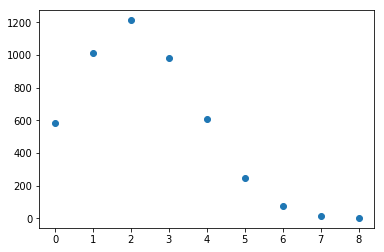

In [201]:
plt.scatter(np.unique(arForHist,return_counts=True)[0],np.unique(arForHist,return_counts=True)[1])

(array([ 580., 1012., 1212.,  978.,    0.,  608.,  246.,   76.,   14.,
           2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

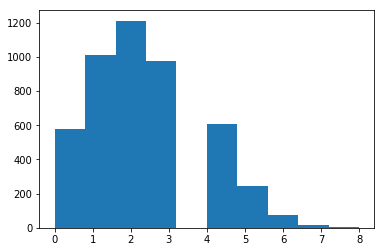

In [202]:
plt.hist(arForHist)

In [111]:
def distanceBetwChains(ch1, ch2, AdjMat):
    """
        Считает расстояние между 1-ой и 2-ой
            цепочкой в графе, заданном матрицей
            смежности
        
        ch1 - первая цепочка
        
        ch2 - вторая цепочка
        
        AdjMat - матрица смежности
    """
    ln = AdjMat.shape[0]
    ansDist = ln
    for i in ch1:
        que = []
        dist = []
        que.append(i)
        dist.append(0)
        visit = [-1 for t in range(ln)]
        visit[i] = 1
        while len(que) != 0:
            for j in range(ln):#Бежим по строке матрицы смежности
                if AdjMat[que[0], j] != 0 and visit[j] == -1:#Если есть ребро + не посетили
                    que.append(j)
                    dist.append(dist[0] + 1)
                    visit[j] = 1
                    
                  
            if que[0] in ch2:
                
                if ansDist > dist[0]:
                    ansDist = dist[0]
            
            del que[0]
            del dist[0]
    return ansDist

In [112]:
mat = np.array([
0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 
0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 
0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 
0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,] )

<img width='450px' src="TestGraph.png"></img>

In [113]:
mat = mat.reshape((12,12))

In [114]:
c1 =[10, 11]
c2 = [4]

In [115]:
distanceBetwChains(c1, c2, mat)

3